# Homework 4 : Model Selection

The goal of this homework is find a suitable model that can distinguish handwritten digits.

In [1]:
import random
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import sklearn
from skimage.feature import hog
import cv2 as cv
import cv2
from sklearn import svm


def prepareData(n=1000):
    """
    Downloads the dataset. Displays some examples.
    Returns the labeled dataset.

    Parameters
    ----------
    n : number of data sample (max 70 000)

    Returns
    -------
    X : Data Matrix
        (n, 28, 28).
    y : labels
        n

    """
    mnist_train = torchvision.datasets.MNIST("./data", download=True,)
    mnist_test = torchvision.datasets.MNIST("./data", download=True, train = False)
    

    
    X = []
    y = []
    for x,label in mnist_train:
        X.append(np.array(x))
        y.append(label)
    
    X_test = []
    y_test = []
    for x,label in mnist_test:
        X_test.append(np.array(x))
        y_test.append(label)
    
    X = np.array(X)
    y = np.array(y)
    X_test= np.array(X_test)
    y_test = np.array(y_test)
    
    
    sample = random.sample(range(len(X)), n)
    X = np.concatenate((X,X_test))[sample]
    y = np.concatenate((y,y_test))[sample]
    
    
    return X,y

def showSamples(X,y):
    fig=plt.figure(figsize=(8, 5))
    columns = 5
    rows = 2
    imgs = [X[i,:,:] for i in range(10)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(X[i-1,:,:] , cmap ="gray")
        plt.axis('off')
        plt.title(str(y[i-1]))
    plt.show()

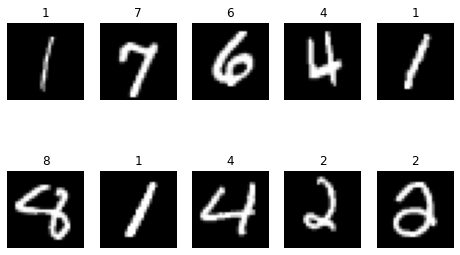

Shape of data matrix X: (1000, 28, 28)
Shape of labels y: (1000,)


In [2]:
X,y = prepareData(1000)
showSamples(X,y)
print("Shape of data matrix X:", X.shape)
print("Shape of labels y:", y.shape)

# Extract features and Train Model

TODO:
- Use any feature extraction method. Compute edges, histogram of oriented gradients, contours etc. to get a more concise representation of the images. 
- Train different models to learn a classification. 
 - You can use any classification model. However, it is easier to use the models from sklearn: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
 

In [3]:
def featureExtractionHog(x):
    """
    Applies a feature extraction on a singular image.

    Parameters
    ----------
    x : ndarray
        a numpy array of shape 28x28

    Returns
    -------
    ndarray
        The resulting feature should be one-dimensional (use x.flatten())
    """
    #TODO: Define a feauture extraction method. 
    # This method is called individually on each data point. 
    # You can also look into methods that do feature extraction on the complete dataset.
    #HOG
    x_hog = hog(x, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=False, multichannel=False)    
    return x_hog.flatten()

def featureExtractionSurf(x):
     #SURF (Speeded-Up Robust Features)
    surf = cv.xfeatures2d.SURF_create(60000)
    kp1,des1 = surf.detectAndCompute(x,None)
    x_surf= cv.drawKeypoints(x,kp1,None,(255,0,0),4)
    return x_surf.flatten()

def featureExtractionFast(x):
    #FAST Algorithm
    fast = cv.FastFeatureDetector_create()
    kp2 = fast.detect(x,None)
    x_fast = cv.drawKeypoints(x,kp2,None,(255,0,0))
    return x_fast.flatten()

def featureExtractionBrief(x):
    #BRIEF (Binary Robust Independent Elementary Features)
    star = cv.xfeatures2d.StarDetector_create()
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    kp3 = star.detect(x,None)
    kp4,des2 = brief.compute(x,kp3)
    x_brief = cv.drawKeypoints(x, kp4, None, color=(0,255,0), flags=0)
    return x_brief.flatten()

def featureExtractionOrb(x):
   #ORB (Oriented FAST and Rotated BRIEF)
    orb = cv.ORB_create()
    kp5 = orb.detect(x,None)
    kp6,des3 = orb.compute(x,kp5)
    x_orb = cv.drawKeypoints(x, kp6, None, color=(0,255,0), flags=0)
    return x_orb.flatten()


def preprocessDataset(X):
    """
    Applies a feature extraction on a dataset

    Parameters
    ----------
    X : ndarray
        Data matrix of size nx28x28
    Returns
    -------
    X_prep : ndarray
        Data matrix of size nxd where d is some dimension of the feature
    """
    
    # TODO: (Optional) You can change this if necessary
    X_prep_hog = []
    X_prep_surf = []
    X_prep_fast = []
    X_prep_brief = []
    X_prep_orb = []
    
    for i in range(len(X)):
        x = X[i,:,:]
        x_hog = featureExtractionHog(x)
        x_surf = featureExtractionSurf(x)
        x_fast = featureExtractionFast(x)
        x_brief = featureExtractionBrief(x)
        x_orb = featureExtractionOrb(x)
        
        X_prep_hog.append(x_hog)  
        X_prep_surf.append(x_surf)    
        X_prep_fast.append(x_fast) 
        X_prep_brief.append(x_brief) 
        X_prep_orb.append(x_orb) 
        
    X_prep_hog = np.array(X_prep_hog)    
    X_prep_surf = np.array(X_prep_surf)
    X_prep_fast = np.array(X_prep_fast)
    X_prep_brief = np.array(X_prep_brief)
    X_prep_orb = np.array(X_prep_orb)
    
    return X_prep_hog,X_prep_surf,X_prep_fast,X_prep_brief,X_prep_orb 
   
def train(X,y):
    # TODO: Select a classifier from sklearn and train it on the data
#     from sklearn.naive_bayes import GaussianNB
#     model = GaussianNB()
#     model.fit(X,y)
    from sklearn.svm import SVC
    model = SVC()
    model.fit(X,y)
    return model

# K-fold Cross Validation

TODO:
- Implement K-Fold Cross Validation
 - Split data into k partitions
 - Train model on k-1 partitions
 - Evaluate model on remaining partition using **Accuracy** as a metric
 - repeat k-times and compute **average Accuracy** over all splits
 
The following code computes cross-validation on a single data split.
Adjust the code to evaluate on multiple splits.

In [4]:
# Number of data samples (reduce number during initial test runs if procedure takes too long)
n = 50000
X,y = prepareData(n)


# Feature extraction
D_hog,D_surf,D_fast,D_brief,D_orb = preprocessDataset(X)

# Number of k-folds
n_splits = 5
train_size = len(X) - len(X)//n_splits


# Cross Validation on a single split: First k-1 splits are used for training and remaining for evaluation.
X_train_hog, X_test_hog = D_hog[:train_size], D_hog[train_size:]
X_train_surf, X_test_surf = D_surf[:train_size], D_surf[train_size:]
X_train_fast, X_test_fast = D_fast[:train_size], D_fast[train_size:]
X_train_brief, X_test_brief = D_brief[:train_size], D_brief[train_size:]
X_train_orb, X_test_orb = D_orb[:train_size], D_orb[train_size:]

y_train, y_test = y[:train_size], y[train_size:]

# Train model
model_hog = train(X_train_hog,y_train)
model_surf = train(X_train_surf,y_train)
model_fast = train(X_train_fast,y_train)
model_brief = train(X_train_brief,y_train)
model_orb = train(X_train_orb,y_train)

# Evaluate model on unseen data
y_pred_hog = model_hog.predict(X_test_hog)
y_pred_surf = model_surf.predict(X_test_surf)
y_pred_fast = model_fast.predict(X_test_fast)
y_pred_brief = model_brief.predict(X_test_brief)
y_pred_orb = model_orb.predict(X_test_orb)

y_pred_train_hog = model_hog.predict(X_train_hog)
y_pred_train_surf = model_surf.predict(X_train_surf)
y_pred_train_fast = model_fast.predict(X_train_fast)
y_pred_train_brief = model_brief.predict(X_train_brief)
y_pred_train_orb = model_orb.predict(X_train_orb)

print("HOG Accuracy Training:", accuracy_score(y_train,y_pred_train_hog))
print("HOG Accuracy Test:", accuracy_score(y_test,y_pred_hog))

print("SURF Accuracy Training:", accuracy_score(y_train,y_pred_train_surf))
print("SURF Accuracy Test:", accuracy_score(y_test,y_pred_surf))

print("FAST Accuracy Training:", accuracy_score(y_train,y_pred_train_fast))
print("FAST Accuracy Test:", accuracy_score(y_test,y_pred_fast))

print("BRIEF Accuracy Training:", accuracy_score(y_train,y_pred_train_brief))
print("BRIEF Accuracy Test:", accuracy_score(y_test,y_pred_brief))

print("ORB Accuracy Training:", accuracy_score(y_train,y_pred_train_orb))
print("ORB Accuracy Test:", accuracy_score(y_test,y_pred_orb))

HOG Accuracy Training: 0.979575
HOG Accuracy Test: 0.9686
SURF Accuracy Training: 0.98885
SURF Accuracy Test: 0.9749
FAST Accuracy Training: 0.9687
FAST Accuracy Test: 0.9416
BRIEF Accuracy Training: 0.9888
BRIEF Accuracy Test: 0.9748
ORB Accuracy Training: 0.9888
ORB Accuracy Test: 0.9748


# Document your model selection

TODO:
- Repeat the previous steps, adjust your feature extraction and classification methods until you get satisfying accuracy results.
- Document your experiments. 
- **Tip:** Adjust the previous code, such that you can run multiple experiments, e.g. run different combinations of feature extractors and classifiers.

##### classifier
- Since the training results were not very good when using the GaussianNB classifier, the SVC classifier was chosen here
- Five methods of feature extraction are compared here

##### Experiment 1: HOG
- Here the hog function is used directly,
- The number of orientation bins is set to 8, size (in pixels) of a cell is set to 8x8,number of cells in each block is set to 2x2

##### Experiment 2: SURF
- it is a speeded-up version of SIFT.
- First I set the Hessian threshold to 60000 and then find the keypoints and descriptors directly.Finally compute the feature points and draw it

##### Experiment 3: FAST
- Here the FAST method is used, initiate the FAST object with the default values and then find and draw the keypoints.

##### Experiment 4: BRIEF
- Here the Brief method is used, initiate the FAST detector and BRIEF detector and then find and draw the keypoints.

##### Experiment 5: ORB
- Here the ORB method is used, initiate the ORB detector and then find and draw the keypoints.